In [1]:
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh, PyMystery_BC
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from matplotlib import rc

Populating the interactive namespace from numpy and matplotlib


Network at address 0x1021fbf60 with 4 nodes and 3 edges



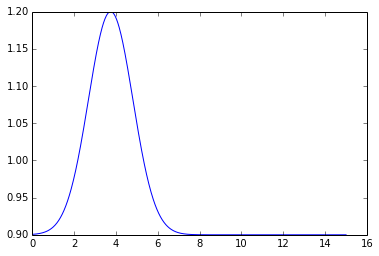

In [2]:
#a = 10; these two work with nodf = 16
#fi =  "indata/3pipes3.inp"        #name of .inp file
#fc = "indata/3pipes3.config"  #name of .config file

# a = 120; these two work with ndof = 8(maybe with 16 but for sure not with 15 or 31)
fi =  "indata/3pipes4.inp"       
fc = "indata/3pipes4.config"
mtype = 1                        #model used along network edges. 1 for Preissman Slot. 0 for uniform
n0 = PyNetwork(fi, fc, mtype)   #a network with Q==0 at boundaries
n1 = PyNetwork(fi, fc, mtype)
print n0 
T = n0.T
M = n0.M
s = linspace(0,T,M+1)
L = n0.Ls[2]
q0 = (.9+.3*exp(-((s-T/4.)*10/T)**2))
q1 = 0*q0[0]*np.ones(size(s))
plot(s,q0)
n0.setbVal(2,q0)
n1.setbVal(2,q1)


In [3]:
#n1.showCurrentData()    
dt = T/M
V00 = n0.getTotalVolume()
n0.runForwardProblem(dt)  #solve up to time T
n1.runForwardProblem(dt)


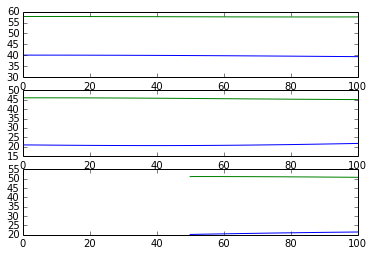

In [4]:
hi0 = [n0.getHofA(i) for i in range(3)]
hi1 = [n1.getHofA(i) for i in range(3)]
fig,ax = plt.subplots(nrows = n0.Nedges)
x0 = [0,0,100.-n0.Ns[2]]
for k in range(n0.Nedges):
    x = np.arange(0,n0.Ls[k], n0.Ls[k]/n0.Ns[k])+x0[k]*np.ones(size(hi1[k]))
    ax[k].plot(x,hi0[k],'b')
    ax[k].plot(x,hi1[k],'g')
    #ax[k].set_ylim([0,ymaxs[i]])
    ax[k].set_xlim([0,100])
    #ax[k].set_yticks(np.linspace(0,ymaxs[i],6))

In [11]:
pj =0
Nstar = 80
#Nstar = 160
qh0 = n0.qhist(pj)
qh1 = n1.qhist(pj)
p1 = PyPipe_ps(n0.Ns[pj], n0.Ds[pj], n0.Ls[pj], M, n0.a[pj])


In [12]:
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

In [13]:

hdata0 = np.array([p1.HofA(qh0[idx_t(0,Nstar,n,n0.Ns[pj])],False) for n in range(M+1)])
hdata1 = np.array([p1.HofA(qh1[idx_t(0,Nstar,n,n0.Ns[pj])],False) for n in range(M+1)])

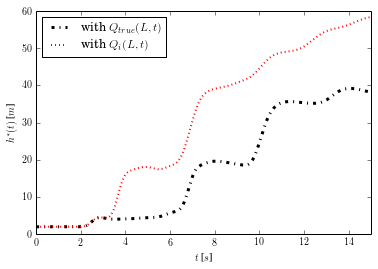

In [14]:
figure()
rc('text', usetex=True)
rc('font', family='serif')
plot(s,hdata0,'k-.',linewidth =3)
plot(s,hdata1,'r:', linewidth=2)
xlim(0,T)
legend([r"with $Q_{true}(L,t)$", r"with $Q_i(L,t)$"], loc = 'upper left')
xlabel('$t$ [$s$]')
ylabel('$h^*(t)$ [$m$]')
plt.savefig("../../optmysteryhofta120.eps")
#savefig('fig_latex.eps')

In [15]:
xstar =float(Nstar)/n0.Ns[pj]*n0.Ls[pj]
whichnode = 2
ndof = 8
modetype = 0
X = q0[0]*ones(ndof)
for i in range(ndof/2):
    X[2*i+1] = 0
X = zeros(ndof)
#print X
#X[0] = 2*q0[0]
print (100./350)*T
print T
delay = 0
qf = q1
dx = n0.Ls[0]/n0.Ns[0]
print n0.a[0]*dt/dx
a = n0.a[0]
D = n0.Ds[0]
print "xstar=%.2f"%xstar
print "slot width = %.5f m "%(D**2/4*np.pi*9.8/a**2)

4.28571428571
15.0
1.02857142857
xstar=200.00
slot width = 0.00053 m 


In [16]:
opt = PyMystery_BC(fi, fc, ndof, np.array(X), hdata0, modetype,pj, xstar, whichnode,qf, delay)
opt2 = PyMystery_BC(fi, fc, ndof, np.array(X), hdata0, 1,pj, xstar, whichnode,qf, delay)

In [17]:
opt.compute_f()
f0 = opt.f
opt2.compute_f()
f02 = opt2.f

In [18]:
bct = opt.getBCtimeseries(0)

In [19]:
opt.solve()
opt2.solve()

In [20]:
opt.dump()
opt2.dump()

In [21]:
Q1 = opt.getBCtimeseries(0)
Q2 = opt2.getBCtimeseries(0)
ff = opt.f
ff2 = opt2.f

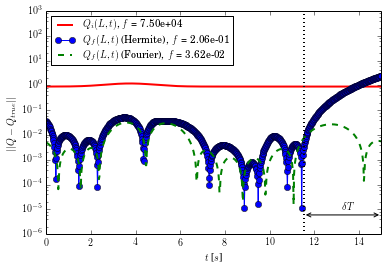

In [22]:

Td = ((n0.Ls[0]-xstar)+n0.Ls[2])/n0.cmax[0]
dM = int(ceil(M*Td/T))
s2 = s[0:M-dM]
#fig, ax = subplots(ncols= 2)
#ax[0].semilogy(s2,abs(Q1[0:M-dM]-q0[0:M-dM]))
semilogy(s,abs(q1-q0),'r',linewidth=2)
semilogy(s, abs(Q1-q0),'b-o')
semilogy(s, abs(Q2-q0),'g--', linewidth = 2)
legend([r"$Q_i(L,t)$, $f$ = %.2e"%f0, r"$Q_f(L,t)$ (Hermite), $f$ = %.2e"%ff,r"$Q_f(L,t)$ (Fourier), $f$ = %.2e"%ff2 ],loc = 'upper left', fontsize =10)
semilogy((T-Td)*ones(10),linspace(1e-7,1000,10),'k:',linewidth=2)
#semilogy(linspace(T-Td,T,10), ones(10)*1e-6,'k',linewidth=2)
#semilogy(Td*ones(10),linspace(1e-7,1,10),'k:',linewidth=2)
plt.annotate(
    '', xy=(T-Td, 6e-6), xycoords='data',
    xytext=(T,6e-6), textcoords='data',
    arrowprops={'arrowstyle': '<->'})
plt.annotate(
    r"$\delta T$", xy=(T-Td+1.5, 1e-5), xycoords='data',
    xytext=(5, 0), textcoords='offset points')
xlabel('$t$ [$s$]')
ylabel('$||Q-Q_{true}||$')
ylim(1e-6,1e3)
xlim(0,T)
#X=opt.x
#plot(np.linspace(0,T,len(xx)/2),xx[0::2],'*')
plt.savefig("../../optmysteryerrora120_hf.eps")

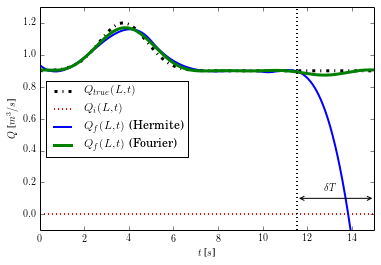

In [23]:
plot(s, q0[0:],'k-.', linewidth = 3)
plot(s,np.zeros(size(s)),'r:', linewidth =2)
plot(s, Q1[0:],'b', linewidth=2)
plot(s, Q2[0:],'g', linewidth=3)
ylim(-.1,1.3)
xlabel('$t$ [$s$]')
X = opt.x
#plot(linspace(0,50,len(X)/2), X[0::2],'*')
#legend([r"$Q_i(L,t)$", r"$Q_{true}(L,t)$"], loc = 'center right')
legend([r"$Q_{true}(L,t)$",r"$Q_i(L,t)$",r"$Q_f(L,t)$ (Hermite)", "$Q_f(L,t)$ (Fourier)"], loc = 'center left')
plt.annotate(
    '', xy=(T-Td, .1), xycoords='data',
    xytext=(T,.1 ), textcoords='data',
    arrowprops={'arrowstyle': '<->'})
plt.annotate(
    r"$\delta T$", xy=(T-Td+1, .15), xycoords='data',
    xytext=(5, 0), textcoords='offset points')
ylabel('$Q$  [$m^3/s$]')
xlim(0,T)
plot((T-Td)*ones(10),linspace(-.1,1.3,10),'k:',linewidth=2)
plt.savefig("../../optmysteryinitial.eps")
#plt.savefig("../../optmysterysoln_a120_hf.eps")

In [24]:
ef = norm(Q1[0:M-dM]-q0[0:M-dM],2)
e0 = norm(q0[0:M-dM])
ef2 = norm(Q2[0:M-dM]-q0[0:M-dM],2)
e02 = norm(q0[0:M-dM])

In [30]:
print "CPU time (s)   &  %4.2f &%4.2f\\\\ "     %(opt.solve_t, opt2.solve_t)
print "actual time (s)&  %4.2f& %4.2f \\\\ " %  (opt.wsolve_t, opt2.wsolve_t)
print "parallel speedup& %1.1f& %1.1f\\\\ "%(opt.solve_t/opt.wsolve_t, opt.solve_t/opt.wsolve_t)
print "$f_i$            &   %.4e& %.4e\\\\  "%(f0, f02)
print "$f_f$            &   %.4e& %.4e\\\\   " %(ff, ff2)
print "$f_i/f_f$         &  %.4e &%.4e \\\\   "%(ff/f0, ff2/f02)
print "$||Q_i - Q_{true}||$ & %.4f& %.4f\\\\"  %(e0, e02)
print "$||Q_f - Q_{true}||$ & %.4f &%.4f\\\\" %(ef, ef2)

CPU time (s)   &  157.53 &137.35\\ 
actual time (s)&  45.90& 41.63 \\ 
parallel speedup& 3.4& 3.4\\ 
$f_i$            &   7.4970e+04& 7.4970e+04\\  
$f_f$            &   2.0603e-01& 3.6163e-02\\   
$f_i/f_f$         &  2.7481e-06 &4.8236e-07 \\   
$||Q_i - Q_{true}||$ & 22.5978& 22.5978\\
$||Q_f - Q_{true}||$ & 0.4799 &0.2967\\


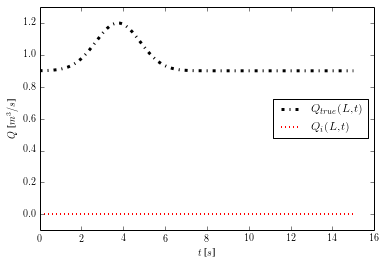

In [26]:
#plot(s,np.zeros(size(s)),'r:', linewidth =2)
plot(s, q0[0:],'k-.', linewidth = 3)
plot(s,np.zeros(size(s)),'r:', linewidth =2)
ylim(-.1,1.3)
xlabel('$t$ [$s$]')
X = opt.x

legend([r"$Q_{true}(L,t)$", r"$Q_i(L,t)$"], loc = 'center right')
ylabel('$Q$  [$m^3/s$]')
plt.savefig("../../optmysteryinitial.eps")

In [27]:
print (max(q0)-min(q0))/min(q0)

0.333333333333


In [28]:
print norm(Q1[0:M-dM]-q0[0:M-dM],2)
print norm(Q1[0:]-q0[0:],2)

0.479935156634
12.8258854604


In [29]:
norm(q0[0:M-dM])

22.597821021245942

In [56]:
dt

0.02142857142857143

In [57]:
n0.cmax[0]*dt

2.627310528101524

In [58]:
print X

[0.9372756284036016, -0.12284074472814399, 1.087307436170531, -0.16908640239279069, 0.8931386970165912, -0.022156921835108513, -1.5016421560831676, -1.7089692655604058]


In [59]:
n0.a

[120.0, 120.0, 120.0]